# Implementing ANNs with Tensorflow
## Homework 2 - 13/11/17
#### Auss Abbood, John Berroa, Luke Effenberger

# Task 2
Downloaded

# Task 3
We use Lukas' helper class to read the data, seen below:

In [1]:
class MNIST():
    def __init__(self, directory):
        self._directory = directory
        
        self._training_data = self._load_binaries("train-images.idx3-ubyte")
        self._training_labels = self._load_binaries("train-labels.idx1-ubyte")
        self._test_data = self._load_binaries("t10k-images.idx3-ubyte")
        self._test_labels = self._load_binaries("t10k-labels.idx1-ubyte")
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)
        
        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype = 'uint8')
                return np.reshape(images, (items_n, height, width))
            elif "labels" in file_name and check == 2049:
                return np.fromfile(fd, dtype = 'uint8')
            else:
                raise ValueError("Not a MNIST file: " + path)
    
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n

# Task 4
Now let's investigate the data.  Let's load the data and plot numbers as well as their labels.  We'll also see the amount of data we have.

In [2]:
# Import for plotting and to get the current directory
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
%matplotlib notebook

cwd = os.getcwd()
mnist_data = MNIST(cwd)

There are 54000 training images, 6000 validation images, and 10000 test images.


<IPython.core.display.Javascript object>


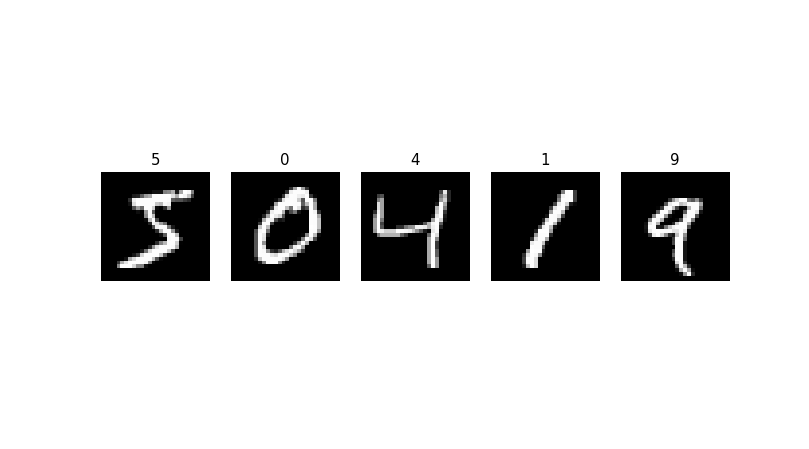

In [3]:
# Get the size of the data so we know what we are working with
n_training, n_valid, n_test = mnist_data.get_sizes()
print("There are {} training images, {} validation images, and {} test images.".format(n_training, n_valid, n_test))
      
# Pull out the first 5 training numbers and their labels for plotting
plotting_samples = mnist_data._training_data[:5]
plotting_labels = mnist_data._training_labels[:5]

fig = plt.figure(figsize = (9,5))

for i in range(len(plotting_samples)):
    fig.add_subplot(1,5,i+1)
    plt.imshow(plotting_samples[i], cmap='gray')
    plt.title(plotting_labels[i])
    plt.xticks([], [])
    plt.yticks([], [])

plt.show()

# Task 5 and 6
We will now implement the dataflow graph for the network within our Neural Network class.  It will have a simple structure: 784 neurons (one for each pixel) and 1 layer (the output layer), of 10 neurons, one for each possible digit.  We also create the code to train it within the class.

In [4]:
#importing tensorflow and sleep for the live graphs
import tensorflow as tf
from time import sleep

In [9]:
class Neural_Network():
    def __init__(self, batchsize, epoch_num, lr=.001, optimizer='standard'):
        """
        Defines the hyperparameters and creates the datasets
        """
        # Initialize the hyperparameters
        self.batch_size = batchsize
        self.learning_rate = lr
        self.epochs = epoch_num
        self.optimizer_choice = optimizer
        
        # Create an MNIST data class
        cwd = os.getcwd()
        self.data = MNIST(cwd)
        
        # Create training sets and a session that can be accessed throughout the class
        self.session = tf.Session()
        self.training = self.data.get_training_batch(self.batch_size)
        self.validation = self.data.get_validation_batch(-1)
        self.test = self.data.get_test_batch(-1)
        
        # Create lists to hold the statistics of the network
        self.loss_list = []
        self.acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []
        self.weights_over_time = []
        
    def flatten(self, batch):
        """
        Flattens a batch into (batchsize, 784), because our network takes in each pixel individually
        Params:
        batch: input batch of shape (?, 28, 28)
        Returns: batch of shape (?, 784)
        """
        flattened = batch.reshape(-1, 784)
        return flattened

    def one_hot(self, lbls):
        """
        Creates one hot labels of the inputting labels, e.g. if 2, it creates [0,0,1,0,0,0...]
        Params:
        lbls: an int of the label
        Returns: one hot version of inputed label
        """
        one_hots = []
        for i, l in enumerate(lbls):
            to_one_hot = np.asarray([0]*10)
            to_one_hot[l] = 1
            one_hots.append(to_one_hot)
        return one_hots
        
        
    def create_and_learn(self):
        """
        The data flow graph.  Creates the graph and trains it on the data.  Also contains two functions, validate and test_final
        """
        def validate():
            """
            Runs the dataflow graph with the validation data.  Returns the weights for plotting later on.
            Returns:
            w: The weights
            """
            valid_loss = 0
            valid_acc = 0
            for batch in self.validation:
                valid_batch = self.flatten(batch[0])
                onehotz_val = self.one_hot(batch[1])
                va, vl, w = self.session.run([accuracy, loss, weights], feed_dict={digits: valid_batch, labels: onehotz_val})
                valid_loss += vl
                valid_acc += va
            self.val_loss_list.append(np.mean(valid_loss))
            self.val_acc_list.append(np.mean(valid_acc))
            self.validation = self.data.get_validation_batch(-1)  # recreate the iterator because it is now empty
            return w

        def test_final():
            """
            Runs the dataflow graph with the test data.  Only run this when a good model is found!
            """
            test_acc_list = []
            test_loss_list = []
            for batch in self.test:
                test_batch = self.flatten(batch[0])
                onehotz_test = self.one_hot(batch[1])
                test_acc, test_loss = self.session.run([accuracy, loss], feed_dict={digits: test_batch, labels: onehotz_test})
                test_acc_list.append(test_acc)
                test_loss_list.append(test_loss)
            print("The final network produces results of\n\nACCURACY: {:.2%}\nLOSS: {:.2f}\n\n".format(test_acc, test_loss))
            print("The hyperparameters and optimizer were:\n\nBATCH SIZE: {}\nLEARNING RATE: {}\nEPOCHS: {}\nOPTIMIZER: {}".format(
                    self.batch_size, self.learning_rate, self.epochs, self.optimizer_choice))
            
        
        # Define the dataflow graph
        digits = tf.placeholder(tf.float32, [None, 784])
        labels = tf.placeholder(tf.float32, [None, 10])
        weights = tf.Variable(tf.random_normal([784,10], stddev=.000002), dtype=tf.float32)
        biases = tf.Variable(tf.zeros(10), dtype=tf.float32)

        drive = tf.matmul(digits, weights) + biases
        output = tf.nn.softmax(drive)

        loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(labels, output))

        # Train it using the chosen optimizer
        if self.optimizer_choice == 'adam':
            self.optimizer_choice = "Adam"
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        elif self.optimizer_choice == 'mom':
            self.optimizer_choice = "Momentum"
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=.5)
        else:
            self.optimizer_choice = "Standard Gradient Descent"
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)

        minimize_loss = optimizer.minimize(loss)

        # See if the position of the maximum value of the label is the same as the maximum value of the output
        correct_bools = tf.equal(tf.argmax(output,1), tf.argmax(labels,1))
        # If so, it is a one, if not, it is a zero.  Take the average of those 1s and 0s to get the accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_bools, tf.float32))
        
    
        self.session.run(tf.global_variables_initializer())
        
        # Now train the graph
        for e in range(self.epochs):
            for i, batch in enumerate(self.training):
                training_batch = self.flatten(batch[0])
                onehotz = self.one_hot(batch[1])

                acc, _loss, _, _ = self.session.run([accuracy, loss, weights, minimize_loss], feed_dict={digits: training_batch, labels: onehotz})

                self.loss_list.append(_loss)
                self.acc_list.append(acc)
                
                if i % 100 == 0:
                    self.weights_over_time.append(validate())
        
        _ = validate() # one last validation to make the plot go to the end of the range
        test_final() # uncomment when ready for testing
        
    def plot(self):
        """
        Plots the loss and accuracy of both the training and validation data in the same graph,
        in order to see performance and also to check for overfitting.
        """
        fig, subplots = plt.subplots(1,2)
        
        plt.sca(subplots[0])
        subplots[0].set_title('Training and Validation Loss')
        subplots[0].set_xlabel('Steps')
        subplots[0].set_ylabel('Cross Entropy Loss')
        # Plot training loss
        x_vals = np.arange(0,len(self.loss_list))
        plt.plot(x_vals, self.loss_list, label='Training')
        # Plot validation loss in same graph
        x_vals = np.arange(0, len(self.loss_list), 100) # to make the x scales equal
        x_vals = np.append(x_vals, len(self.loss_list))
        plt.plot(x_vals, self.val_loss_list, label='Validation')
        plt.legend()
        
        plt.sca(subplots[1])
        subplots[1].set_title('Training and Validation Accuracy')
        subplots[1].set_xlabel('Steps')
        subplots[1].set_ylabel('Accuracy')
        # Plot training accuracy
        x_vals = np.arange(0,len(self.acc_list))
        plt.plot(x_vals, self.acc_list, label='Training')
        # Plot validation accuracy in same graph
        x_vals = np.arange(0, len(self.acc_list), 100) # to make the x scales equal
        x_vals = np.append(x_vals, len(self.acc_list))
        plt.plot(x_vals, self.val_acc_list, label='Validation')
        plt.legend()
        
        plt.suptitle("Network Performance (Batch: {}|LrnRate: {}| Optimzr: {})".format(self.batch_size, self.learning_rate, self.optimizer_choice))
        plt.show()
        
    def plot_weights(self):
        """
        Plots the weights that were collected during the validation tests
        """
        figW, axW = plt.subplots(2, 5, figsize=(8,7))
        self.weights_over_time = np.asarray(self.weights_over_time)
        
        for i in range(len(self.val_loss_list)-1):
            for num in range(10):
                if num < 5: # the conditional is used because there is two rows in the graph (5x5 instead of 1x10)
                    plt.sca(axW[0][num])
                    axW[0][num].cla()
                    axW[0][num].set_title("Weights for {}".format(num))
                    wt = self.weights_over_time[i,:,num].reshape(28, 28) # reshape the 784 weights into images again
                    axW[0][num].matshow(wt, cmap = plt.get_cmap('bwr'))
                    axW[0][num].set_xticks([],[])
                    axW[0][num].set_yticks([],[])
                else:
                    plt.sca(axW[1][num-5])
                    axW[1][num-5].cla()
                    axW[1][num-5].set_title("Weights for {}".format(num))
                    wt = self.weights_over_time[i,:,num].reshape(28, 28) # reshape the 784 weights into images again
                    axW[1][num-5].matshow(wt, cmap = plt.get_cmap('bwr'))
                    axW[1][num-5].set_xticks([],[])
                    axW[1][num-5].set_yticks([],[])

            figW.canvas.draw()
            sleep(.05)     

# Task 6.1
We will now plot the weights over time to see how they evolve.  The weights can be visualized because each output neuron gets 784 inputs...the same amount as the number of pixels in the original images.  And so each series of weights going into each output neuron corresponds to some sort of representation of that number, and all we have to do is reshape that representation back in (28, 28) in order to see it.

<IPython.core.display.Javascript object>


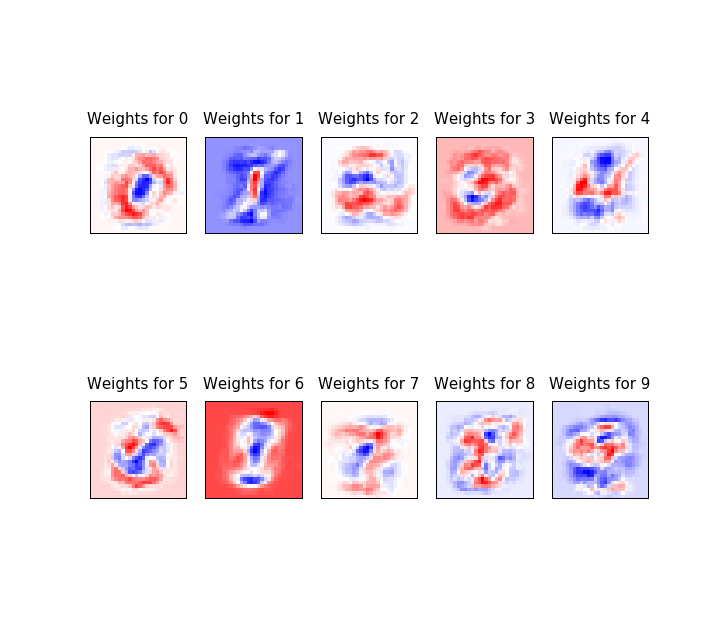

In [6]:
# Create the network, train it, then plot the weights
net = Neural_Network(batchsize=200, epoch_num=3)
net.create_and_learn()
net.plot_weights()

# Task 7
We try out a whole bunch of various batch size, learning rate, and optimizer combinations.  We then see which one gives the best numbers, and run the test set on it.

<IPython.core.display.Javascript object>


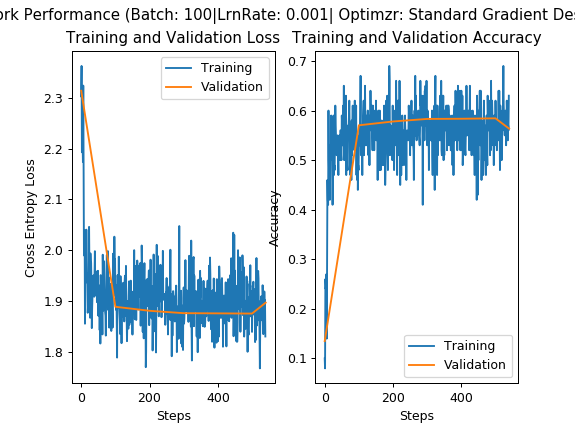

The performance of this network on the validation data is:
Accuracy: 56.35%
Loss: 1.90


<IPython.core.display.Javascript object>


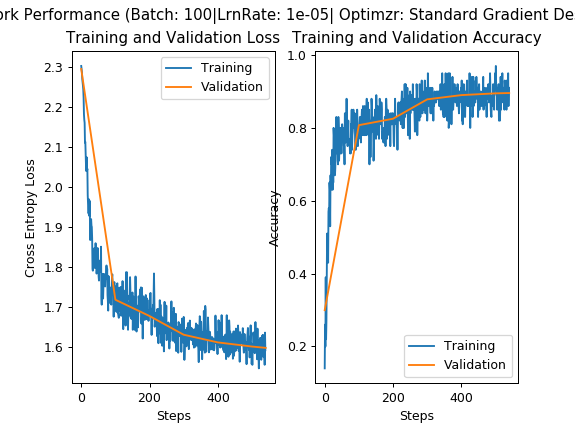

The performance of this network on the validation data is:
Accuracy: 89.57%
Loss: 1.60


<IPython.core.display.Javascript object>


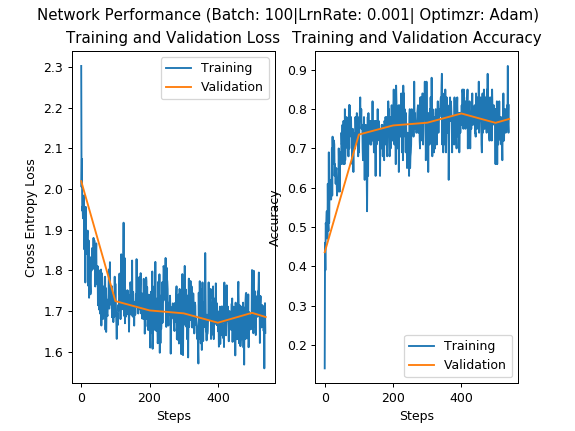

The performance of this network on the validation data is:
Accuracy: 77.50%
Loss: 1.69


<IPython.core.display.Javascript object>


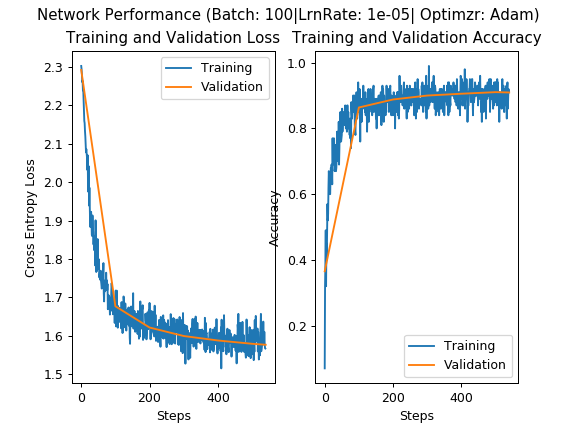

The performance of this network on the validation data is:
Accuracy: 90.93%
Loss: 1.58


<IPython.core.display.Javascript object>


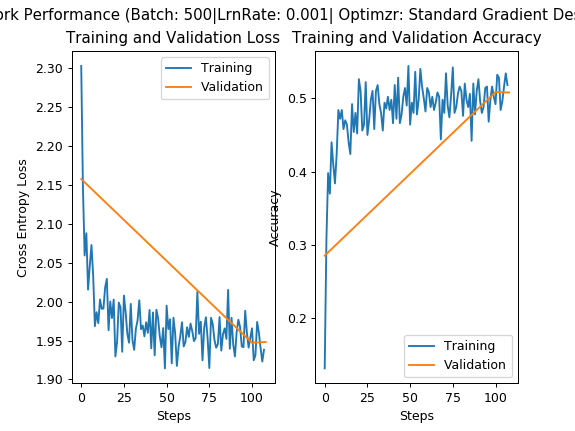

The performance of this network on the validation data is:
Accuracy: 50.78%
Loss: 1.95


<IPython.core.display.Javascript object>


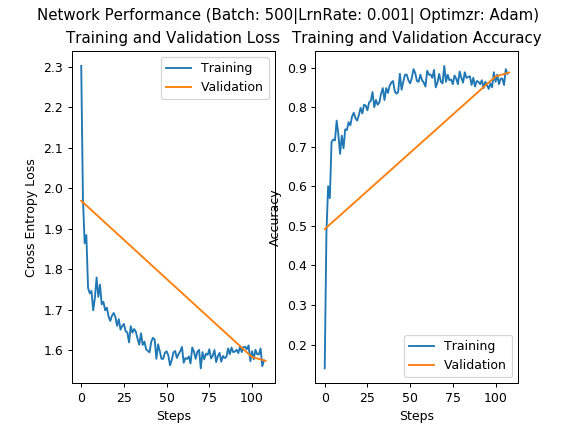

The performance of this network on the validation data is:
Accuracy: 88.75%
Loss: 1.57


<IPython.core.display.Javascript object>


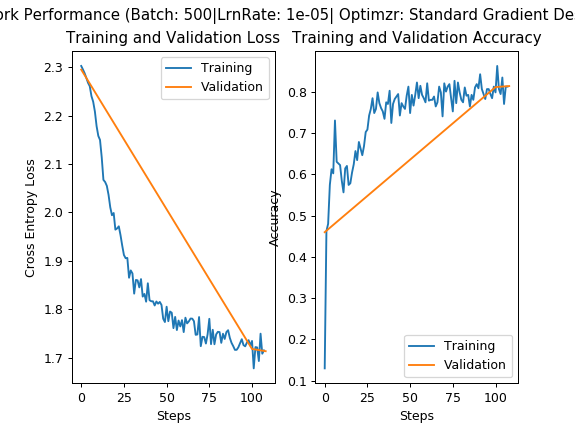

The performance of this network on the validation data is:
Accuracy: 81.33%
Loss: 1.71


<IPython.core.display.Javascript object>


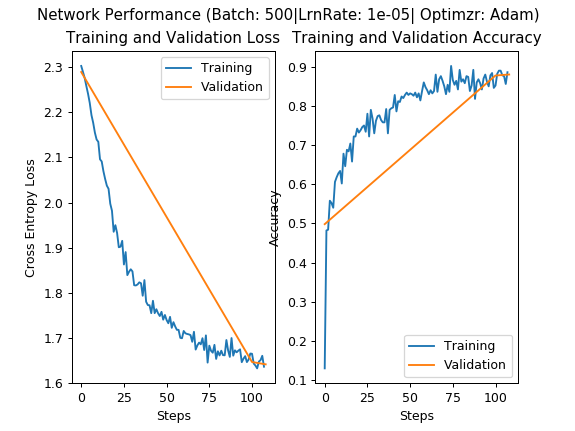

The performance of this network on the validation data is:
Accuracy: 88.02%
Loss: 1.64


<IPython.core.display.Javascript object>


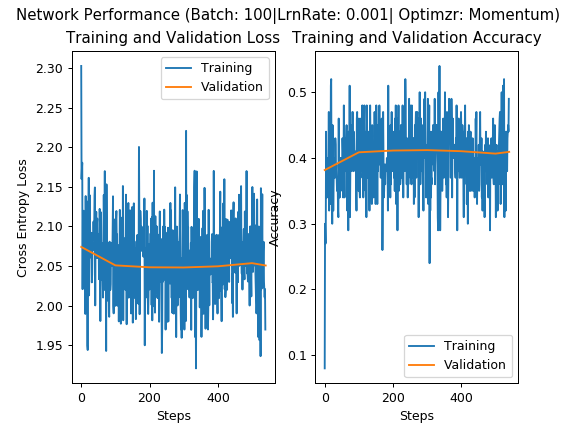

The performance of this network on the validation data is:
Accuracy: 40.93%
Loss: 2.05


<IPython.core.display.Javascript object>


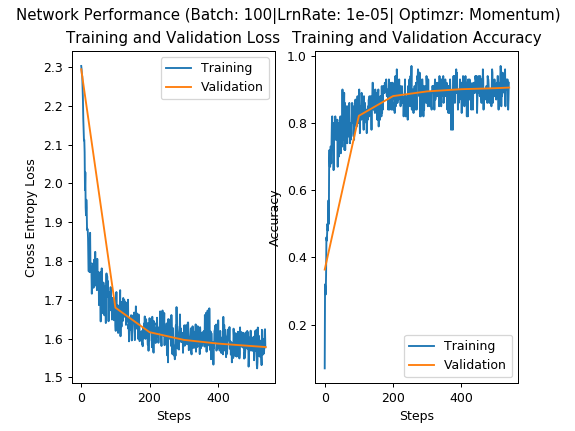

The performance of this network on the validation data is:
Accuracy: 90.57%
Loss: 1.58


<IPython.core.display.Javascript object>


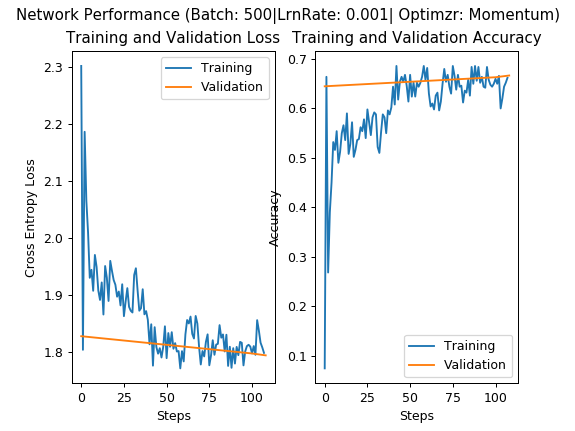

The performance of this network on the validation data is:
Accuracy: 66.67%
Loss: 1.79


<IPython.core.display.Javascript object>


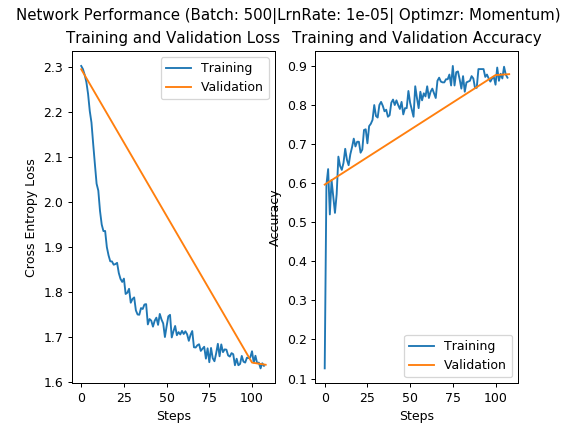

The performance of this network on the validation data is:
Accuracy: 87.90%
Loss: 1.64


<IPython.core.display.Javascript object>


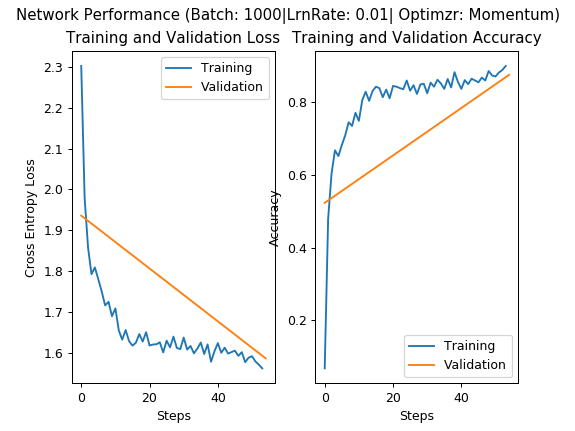

The performance of this network on the validation data is:
Accuracy: 87.57%
Loss: 1.59


<IPython.core.display.Javascript object>


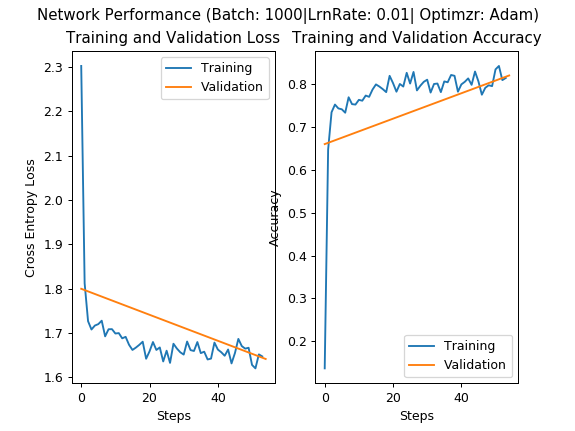

The performance of this network on the validation data is:
Accuracy: 81.98%
Loss: 1.64


In [8]:
test_cases = []
test_cases.append([100,.001, 'sgd'])
test_cases.append([100,.00001, 'sgd'])
test_cases.append([100,.001, 'adam'])
test_cases.append([100,.00001, 'adam'])
test_cases.append([500,.001, 'sgd'])
test_cases.append([500,.001, 'adam'])
test_cases.append([500,.00001, 'sgd'])
test_cases.append([500,.00001, 'adam'])
test_cases.append([100,.001, 'mom'])
test_cases.append([100,.00001, 'mom'])
test_cases.append([500,.001, 'mom'])
test_cases.append([500,.00001, 'mom'])
test_cases.append([1000,.01, 'mom'])
test_cases.append([1000,.01, 'adam'])



for t in range(len(test_cases)):
    net = Neural_Network(batchsize=test_cases[t][0], epoch_num=3, lr=test_cases[t][1], optimizer=test_cases[t][2])
    net.create_and_learn()
    net.plot()
    print("The performance of this network on the validation data is:\nAccuracy: {:.2%}\nLoss: {:.2f}".format(net.val_acc_list[-1], net.val_loss_list[-1]))


        

We found the '[100,.00001, 'adam'])' network to work the best, after a few trials, so we'll recreate it with the testing code uncommented (we could just run the test function directly if it was the last net we created, but since we overwrite 'net' everytime we run a test, we have to do it this way.

The final network produces results of

ACCURACY: 91.23%
LOSS: 1.57


The hyperparameters and optimizer were:

BATCH SIZE: 100
LEARNING RATE: 1e-05
EPOCHS: 3
OPTIMIZER: Adam


<IPython.core.display.Javascript object>


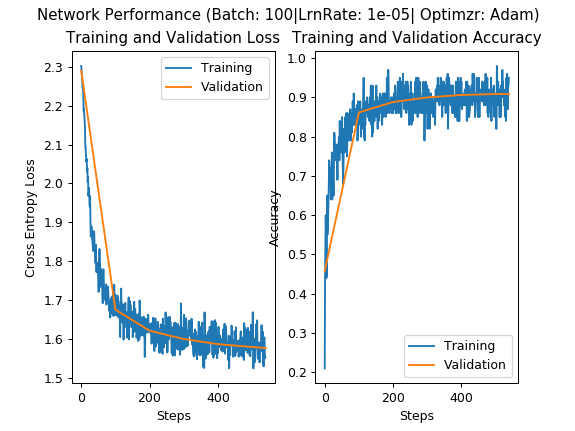

In [10]:
final_net = Neural_Network(batchsize=100, epoch_num=3, lr=.00001, optimizer='adam')
final_net.create_and_learn()
final_net.plot()